In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path


In [3]:
def plot_phantom_views(phantom_base, title, show_yz = False):
        # Get center coordinates
        center_x = phantom_base.shape[0]//2
        center_y = phantom_base.shape[1]//2
        center_z = phantom_base.shape[2]//2

        # Plot the phantom from different views
        plt.figure(figsize=(15, 5))
        if show_yz:
            # Sagittal view (YZ plane, middle of X)
            plt.subplot(131)
            plt.imshow(phantom_base[center_x, :, :], cmap='gray')
            plt.title('Sagittal View (YZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('Y axis')

            # Coronal view (XZ plane, middle of Y)
            plt.subplot(132)
            plt.imshow(phantom_base[:, center_y, :], cmap='gray', aspect='equal')
            plt.title('Coronal View (XZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('X axis')
        
            # Axial view (XY plane, middle of Z)
            plt.subplot(133)
            plt.imshow(phantom_base[:, :, center_z], cmap='gray', aspect='equal')
            plt.title('Axial View (XY plane)')
            plt.xlabel('Y axis')
            plt.ylabel('X axis')
        else:
            # Coronal view (XZ plane, middle of Y)
            plt.subplot(121)
            plt.imshow(phantom_base[:, center_y, :], cmap='gray', aspect='equal')
            plt.title('Coronal View (XZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('X axis')
        
            # Axial view (XY plane, middle of Z)
            plt.subplot(122)
            plt.imshow(phantom_base[:, :, center_z], cmap='gray', aspect='equal')
            plt.title('Axial View (XY plane)')
            plt.xlabel('Y axis')
            plt.ylabel('X axis')

        plt.suptitle(title, fontsize=14)

        # Turn off axis numbers for all subplots
        for ax in plt.gcf().axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

In [4]:
def add_phantom_base(base_value, phantom_size=200, phantom_height = 52, matrix_size = (182,64,182), FOV_xz = 300, plot = False):
    # phantom base
    # Create a 182 x 64 x 182 matrix filled with zeros
    phantom_base = np.zeros(matrix_size)

    # Calculate voxel size in mm
    # Assume FOV is 300x300mm in xz plane
    voxel_size = FOV_xz/matrix_size[0]  # approximately 1.648 mm per voxel for 182 dimmension

    # Calculate cylinder dimensions in voxels
    cylinder_height = int(phantom_height/voxel_size)  # height in voxels
    cylinder_radius = int((phantom_size/2)/voxel_size)  # radius in voxels

    # Get the center coordinates
    center_x = phantom_base.shape[0]//2
    center_y = phantom_base.shape[1]//2
    center_z = phantom_base.shape[2]//2

    # Create cylinder
    for x in range(phantom_base.shape[0]):
        for y in range(phantom_base.shape[1]):
            for z in range(phantom_base.shape[2]):
                # Check if point is within cylinder bounds
                if ((x - center_x)**2 + (z - center_z)**2 <= cylinder_radius**2 and 
                    abs(y - center_y) <= cylinder_height//2):
                    phantom_base[x,y,z] = base_value

    # Call the plotting function
    if plot:
        plot_phantom_views(phantom_base, 'Phantom Test Object Base')

    return phantom_base, voxel_size

In [5]:
def add_rotated_cubes(phantom_base, cube_size, rotation_angle = np.pi/6, cube1_value=1, cube2_value=2, plot = False):
    # Create a matrix for the rotated cubes with same dimensions as phantom_base
    cube_size = int(np.floor(cube_size))
    cube_phantom = np.zeros_like(phantom_base)

    center_x = phantom_base.shape[0]//2
    center_y = phantom_base.shape[1]//2
    center_z = phantom_base.shape[2]//2
    # Extract dimensions from phantom_base
    if phantom_base is None:
        raise ValueError("phantom_base cannot be None")
        
    # Get cylinder dimensions from phantom_base shape
    phantom_size = phantom_base.shape[0]  # Assuming cubic phantom
    cylinder_radius = phantom_size // 4    # Radius is 1/4 of phantom size
    # Define cube parameters
      # 30 degree rotation

    # Define the first cube vertices in XZ plane (before rotation)
    # Positioning in top left quadrant
    cube1_center_x = center_x - cylinder_radius//2 
    cube1_center_z = center_z - cylinder_radius//2

    vertices1_xz = np.array([
        [cube1_center_x - cube_size//2, cube1_center_z - cube_size//2],  # bottom left
        [cube1_center_x + cube_size//2, cube1_center_z - cube_size//2],  # bottom right
        [cube1_center_x + cube_size//2, cube1_center_z + cube_size//2],  # top right
        [cube1_center_x - cube_size//2, cube1_center_z + cube_size//2]   # top left
    ])
    # Define the second cube vertices in XZ plane (before rotation)
    # Positioning in top right quadrant
    cube2_center_z = center_x + cylinder_radius//2  # Positive to move to right quadrant
    cube2_center_x = center_z - cylinder_radius//2  # Negative to move to top quadrant

    vertices2_xz = np.array([
        [cube2_center_x - cube_size//2, cube2_center_z - cube_size//2],  # bottom left
        [cube2_center_x + cube_size//2, cube2_center_z - cube_size//2],  # bottom right
        [cube2_center_x + cube_size//2, cube2_center_z + cube_size//2],  # top right
        [cube2_center_x - cube_size//2, cube2_center_z + cube_size//2]   # top left
    ])

    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])

    # Apply rotation to vertices of both cubes
    center_point1 = np.array([cube1_center_x, cube1_center_z])
    rotated_vertices1 = np.array([
        np.dot(rotation_matrix, (vertex - center_point1)) + center_point1
        for vertex in vertices1_xz
    ])

    center_point2 = np.array([cube2_center_x, cube2_center_z])
    rotated_vertices2 = np.array([
        np.dot(rotation_matrix, (vertex - center_point2)) + center_point2
        for vertex in vertices2_xz
    ])

    # Create the cubes across all relevant Y slices
    y_start = center_y - cube_size//2
    y_end = center_y + cube_size//2

    for y in range(y_start, y_end):
        # Create a mesh grid for this slice
        x_coords, z_coords = np.meshgrid(np.arange(phantom_base.shape[0]), 
                                        np.arange(phantom_base.shape[2]), 
                                        indexing='ij')
        points = np.column_stack((x_coords.ravel(), z_coords.ravel()))
        
        # Create paths for both rotated squares
        square_path1 = Path(rotated_vertices1)
        square_path2 = Path(rotated_vertices2)
        
        # Check which points are inside each square separately
        mask1 = square_path1.contains_points(points).reshape(phantom_base.shape[0], phantom_base.shape[2])
        mask2 = square_path2.contains_points(points).reshape(phantom_base.shape[0], phantom_base.shape[2])
        
        # Fill the cubes in this slice with different values
        cube_phantom[:, y, :] = mask1.astype(int) * cube1_value + mask2.astype(int) * cube2_value

    # Only keep cube points that are also within the cylinder
    cube_phantom = cube_phantom * phantom_base
    # Call the plotting function
    if plot:
        plot_phantom_views(phantom_base, 'Phantom Cubes')
    
    return cube_phantom


In [6]:
def add_phantom_ring(phantom_base, outer_rad, inner_rad, value, plot = False):
    # Create a cylindrical ring by subtracting a smaller cylinder from a larger one
    matrix_size = phantom_base.shape
    large_cylinder, _ = add_phantom_base(1, outer_rad, matrix_size=matrix_size)  # Larger cylinder
    small_cylinder, _ = add_phantom_base(1, inner_rad, matrix_size=matrix_size)  # Smaller cylinder
    ring_phantom = (large_cylinder - small_cylinder) * value  # Subtract and fill with value 0.8
    if plot:
        plot_phantom_views(ring_phantom,'')
    return ring_phantom  # Was missing return statement

In [7]:
def add_four_cylinders(phantom_base, small_radius=20, distance_from_center_voxel=40, value=0.5, plot=False):
    """
    Adds 4 identical cylinders arranged in a cross pattern inside a base cylinder
    
    Parameters:
    -----------
    small_radius : float
        Radius of the four smaller cylinders
    distance_from_center : float
        Distance from the edge of base cylinder to the centers of small cylinders
    value : float
        Value to fill the cylinders with
    plot : bool
        Whether to plot the result
    """
    result = np.zeros_like(phantom_base)
    
    # Get the center coordinates
    center_x = result.shape[0]//2
    center_y = result.shape[1]//2
    center_z = result.shape[2]//2

    # Find the height of the cylinder by checking non-zero values along y-axis
    non_zero_y = np.any(phantom_base != 0, axis=(0,2))

    cylinder_height = np.sum(non_zero_y)
    # Create cylinder
    cylinder_mask = result.copy()
    for x in range(result.shape[0]):
        for y in range(result.shape[1]):
            for z in range(result.shape[2]):
                # Check if point is within cylinder bounds
                if ((x - (center_x+distance_from_center_voxel))**2 + (z - center_z)**2 <= small_radius**2 and 
                    abs(y - center_y) <= cylinder_height//2):
                    cylinder_mask[x,y,z] = value

    # Create a flipped version of the cylinder along x-axis
    flipped_cylinder = np.flip(cylinder_mask, axis=0)
    cylinder_mask += flipped_cylinder

    # Rotate cylinder mask 90 degrees in XZ plane by transposing X and Z axes
    rotated_cylinder = np.transpose(cylinder_mask, (2, 1, 0))
    cylinder_mask += rotated_cylinder

    result += cylinder_mask

    if plot:
        plot_phantom_views(result, 'Four Cylinders')
        
    return result


In [8]:
def add_phantom_rectangle(phantom_base, rect_width, rect_length, x_offset=0, z_offset=0, n_line=1, value1=0.5, value2=0, plot=False):
    """
    Adds a rectangle to the phantom in the x-z plane
    
    Parameters:
    -----------
    phantom_base : ndarray
        Base phantom to add rectangle to
    rect_width : int
        Width of rectangle (x dimension)
    rect_length : int
        Length of rectangle (z dimension) 
    center_y : int
        Y coordinate for center of rectangle
    value : float
        Value to fill the rectangle with
    plot : bool
        Whether to plot the result
    """
    # Initialize phantom
    rect_phantom = np.zeros_like(phantom_base)
    
    # Get center coordinates
    center_x = phantom_base.shape[0]//2 + x_offset
    center_y = phantom_base.shape[1]//2
    center_z = phantom_base.shape[2]//2 + z_offset

    non_zero_y = np.any(phantom_base != 0, axis=(0,2))
    cylinder_height = np.sum(non_zero_y)
    # Calculate rectangle bounds
    x_start = int(center_x - rect_width//2)
    x_end = int(center_x + rect_width//2)
    z_start = int(center_z - rect_length//2) 
    z_end = int(center_z + rect_length//2)
    # Create the rectangle across relevant Y slices
    y_start = center_y - cylinder_height//2
    y_end = center_y + cylinder_height//2

    if n_line == 0:
        # Just use value1 for all slices
        for x in range(x_start, x_end):
            rect_phantom[x, y_start:y_end, z_start:z_end] = value1
    else:
        # Calculate width of each alternating section
        section_width = (x_end - x_start) // n_line
        
        for i in range(n_line):
            section_start = x_start + i * section_width
            section_end = x_start + (i + 1) * section_width if i < n_line - 1 else x_end
            # Alternate between value1 and value2
            current_value = value1 if i % 2 == 0 else value2
            
            for x in range(section_start, section_end):
                rect_phantom[x, y_start:y_end, z_start:z_end] = current_value

    # Only keep rectangle points that are within the cylinder
    rect_phantom = rect_phantom * phantom_base
    
    if plot:
        plot_phantom_views(rect_phantom, 'Phantom Rectangle')
        
    return rect_phantom



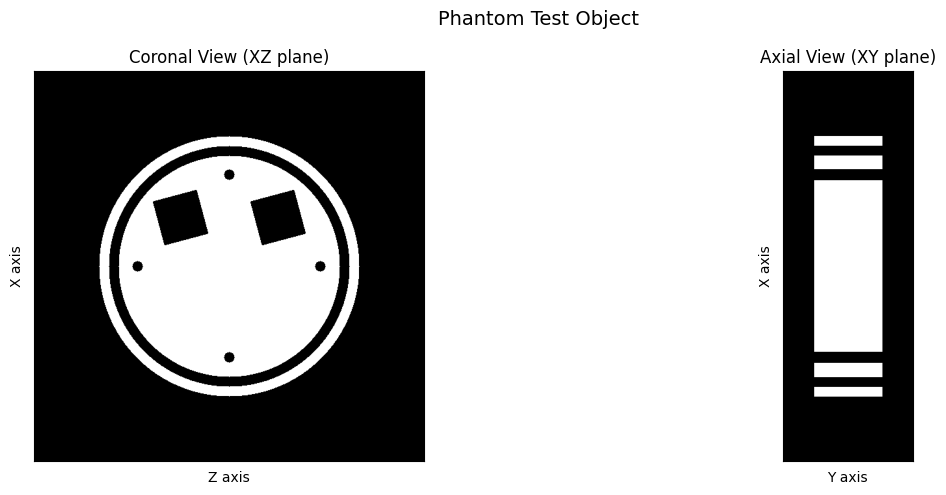

In [9]:
base_rad = 200 #in mm
base_height = 52
FOV_xz = 300 # code assumes x and z dimension have size FOV
# matrix_size = (600,200,600)# determines resolution
matrix_size = (600,200,600)
cube_size = 35
ring_outer_rad = 185
ring_inner_rad = 170
small_cylinder_rad = 4
small_cylinder_dist = 70

phantom_base, voxel_size = add_phantom_base(1, base_rad, base_height, matrix_size, FOV_xz)
phantom_cube = add_rotated_cubes(phantom_base, cube_size/voxel_size, np.pi/12, -1, -1)
phantome_ring = add_phantom_ring(phantom_base, ring_outer_rad, ring_inner_rad, -1)
phantome_small_cylinders = add_four_cylinders(phantom_base, small_cylinder_rad/voxel_size, small_cylinder_dist/voxel_size, -1)


combined_phantom_nolines = phantom_base + phantom_cube + phantome_ring + phantome_small_cylinders


plot_phantom_views(combined_phantom_nolines,'Phantom Test Object')

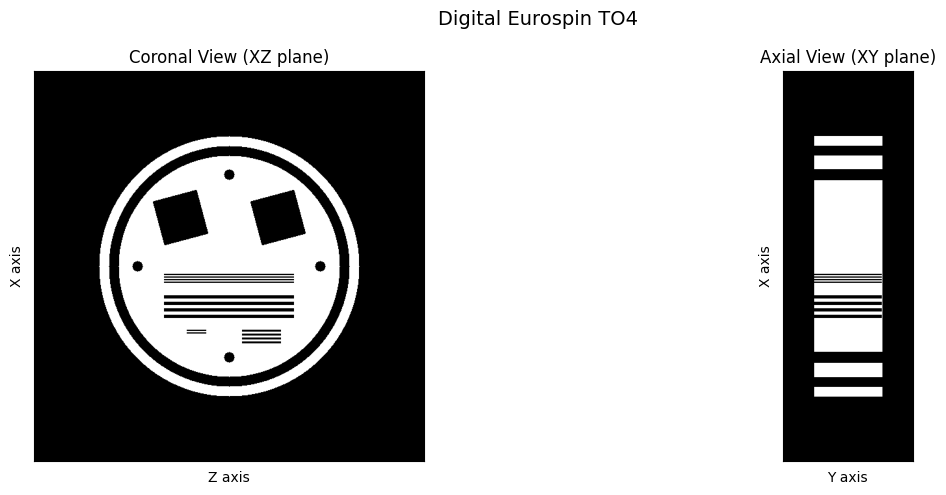

In [10]:
phantom_lines1 = add_phantom_rectangle(phantom_base, 10/voxel_size, 100/voxel_size, x_offset = 10/voxel_size, n_line=9, value1 = 0, value2 = -1)
phantom_lines2 = add_phantom_rectangle(phantom_base, 20/voxel_size, 100/voxel_size, x_offset = 30/voxel_size, n_line=8, value1 = 0, value2 = -1)
phantom_lines3 = add_phantom_rectangle(phantom_base, 15/voxel_size, 30/voxel_size, x_offset = 55/voxel_size, z_offset= 25/voxel_size, n_line=9, value1 = 0, value2 = -1)
phantom_lines4 = add_phantom_rectangle(phantom_base, 4/voxel_size, 15/voxel_size, x_offset = 50/voxel_size, z_offset= -25/voxel_size, n_line=4, value1 = 0, value2 = -1)


combined_phantom = ( phantom_base + phantom_cube + phantome_ring + phantome_small_cylinders 
+ phantom_lines1 + phantom_lines2 + phantom_lines3 + phantom_lines4 )

plot_phantom_views(combined_phantom,'Digital Eurospin TO4')